In [411]:
import os
import numpy as np
import pyshtools as sh
import matplotlib.pyplot as plt

import spherical_inr as sph
import torch
import pickle as pk
import s2fft

import scripts
from scripts._units import *

### Setup

In [412]:
rng = np.random.default_rng()

In [413]:
L_gt = 120 
L_train = 100

file_name = "spice/data/jgmro_120d_sha.tab"
coeffs, r_0, gm = scripts.read_SHADR(file_name)
cnm_gt = coeffs[:, : L_gt + 1, : L_gt + 1]

In [414]:
r_star =r_0
u_star = gm / r_star
a_star = u_star / r_star

print(
    f"u_star = {u_star} [m^2/s^2]",
    f"r_star = {r_star} [m]",
    f"a_star = {a_star} [m/s^2]",
    sep="\n"
)

u_star = 12611418.084733834 [m^2/s^2]
r_star = 3396000.0 [m]
a_star = 3.7136095655871126 [m/s^2]


### HNET 
Model for Gravimetry Problem 

In [415]:
torch.manual_seed(0)
hnet =scripts.GravityHNet(
    inr_sizes = [8] + 2*[100],
    activation = "srelu",
    init=True,
    normalize=False, 
)

### SH Transform

In [416]:
r, phi, theta, (nlon, nlat) = scripts.s2_grid(R = 1.0, L = L_gt, sampling="gl")
X_sh = torch.stack([r.flatten(), theta.flatten(), phi.flatten()], dim = -1)

In [417]:
def get_coeffs(Y_sh:torch.Tensor):
    
    coeffs = np.zeros((nlat, nlon), dtype = np.complex128)
    Y_sh_numpy = Y_sh.detach().clone().flatten().numpy().reshape(nlat, nlon, -1)
    for i in range(Y_sh_numpy.shape[-1]):
        coeffs += s2fft.forward_numpy(Y_sh_numpy[..., i], L = L_gt, sampling ="gl")
        
    return coeffs


## HNET Potential 

Testing set common to all cases

In [418]:
xyz_coords_test, sph_coords_test = scripts.points_from_grid(L_gt, r=(r_0 * 1.1), use_GLQ_grid=True)

In [419]:
sph_coords_test_scaled = sph_coords_test.copy()
sph_coords_test_scaled[:, 0] /= r_star

xtest= torch.tensor(sph_coords_test_scaled.copy(), dtype=torch.float32)
ytest= hnet(xtest) 

**TESTING DATA**

In [420]:
X_test = xtest.clone().detach().numpy()
Y_test = u_star * ytest.clone().detach().numpy().reshape((L_gt+1, 2*(L_gt+1) - 1))

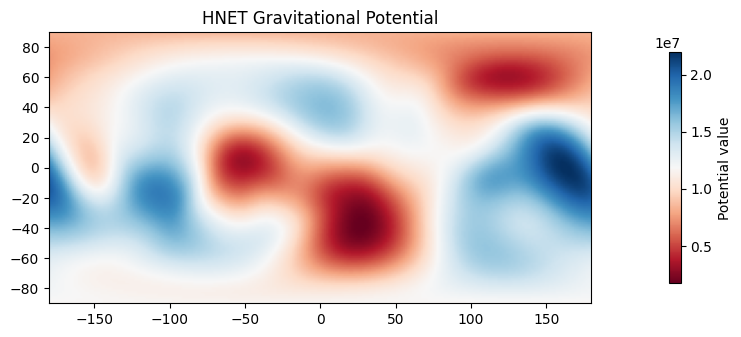

In [421]:
fig = plt.figure(figsize=(20, 15), dpi = 100)

_, ax = scripts.plot_s2(Y_test,   fig= fig, cmap = "RdBu")
ax.set_title("HNET Gravitational Potential")
cbar = fig.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', shrink=0.2, fraction = 0.6)
cbar.ax.set_ylabel('Potential value')


plt.show()

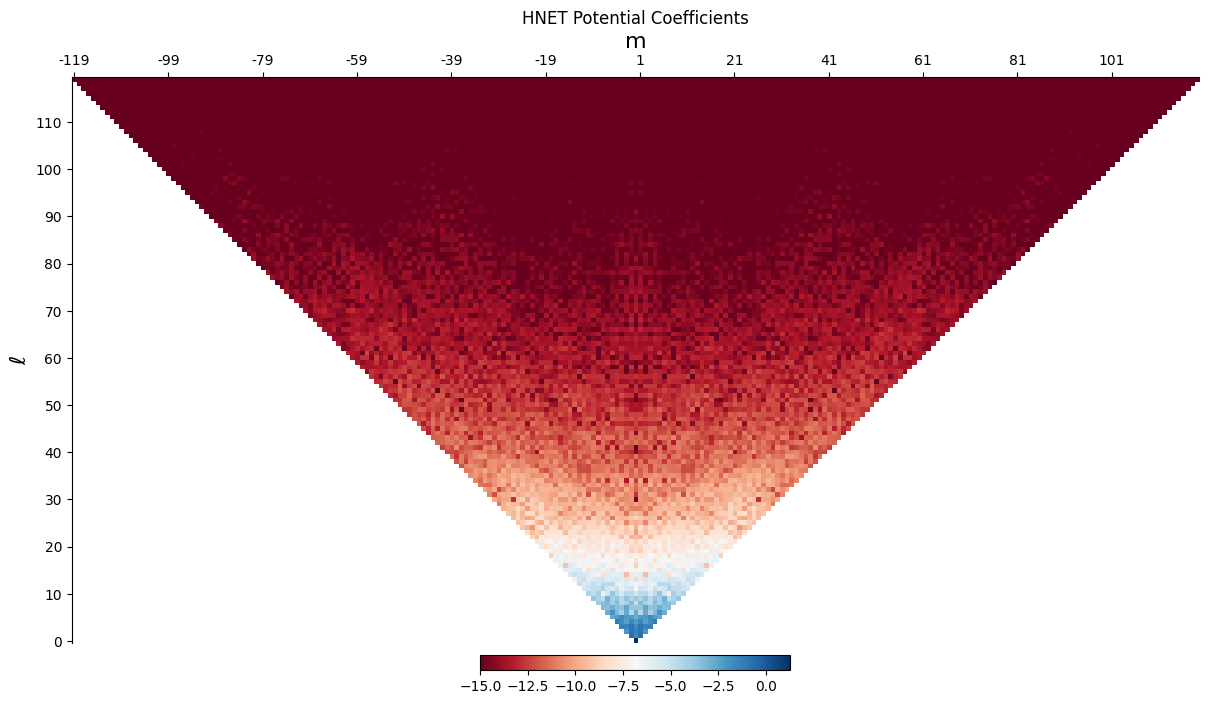

In [422]:
sh_coeffs = get_coeffs(hnet(X_sh))

fig = plt.figure(figsize=(20, 15), dpi = 100)

vmin = -15
vmax = np.max(np.log(np.abs(sh_coeffs)))

_, ax = scripts.plot_shcoeffs(sh_coeffs, fig=fig, ticks_m=20, cmap = "RdBu", norm = plt.Normalize(vmin=vmin, vmax=vmax))
ax.set_title("HNET Potential Coefficients")
fig.colorbar(ax.images[0], ax = ax, orientation="horizontal", shrink=0.2, fraction = .5, pad = .01)

plt.show()

## Case 1 : GLG Grid

In [423]:
xyz_coords_train_glq, sph_coords_train_glq = scripts.points_from_grid(L_train, r=(r_0 + 234.0 * km)) 

sph_coords_train_glq_scaled = sph_coords_train_glq.copy()
sph_coords_train_glq_scaled[:, 0] /= r_star

xtrain_glq= torch.tensor(sph_coords_train_glq_scaled.copy(), dtype=torch.float32)
ytrain_glq= hnet(xtrain_glq)

**DATA CASE 1**

In [424]:
X_train_glq = sph_coords_train_glq
Y_train_glq = u_star * ytrain_glq.clone().detach().numpy().reshape((L_train+1, 2*(L_train+1) - 1))

## Case 2 : Circular Trajectory

In [425]:
t_vec = scripts.measurement_schedule(
        t_span=365 * day, dt = 60.* sec, passes_per_day=1, pass_length=4 * hour, random_track_start=True, rng=rng
)

xyz_coords_train_circ, sph_coords_train_circ, _ = scripts.points_from_keplerian_traj(
    gm,
    t_vec,  
    coverage=1.0, 
    elts=dict(
        a=3630 * km, i=92.6 * deg, e=0.00, om=270 * deg, Om=0.0 * deg, M_0=0.0 * deg
    ),
)

sph_coords_train_circ_scaled = sph_coords_train_circ.copy()
sph_coords_train_circ_scaled[:, 0] /= r_star

xtrain_circ= torch.tensor(sph_coords_train_circ_scaled.copy(), dtype=torch.float32)
ytrain_circ= hnet(xtrain_circ)

100%|██████████| 365/365 [00:00<00:00, 52509.72it/s]


**DATA CASE 2**

In [426]:
X_train_circ = sph_coords_train_circ
Y_train_circ = u_star * ytrain_circ.clone().detach().numpy().reshape(-1)

## Case 3 : Eccentric Orbits

In [427]:
e_mex = 0.57
r_p_mex = 298*km+r_0 
a_mex = r_p_mex/(1-e_mex)


t_vec = scripts.measurement_schedule(
        t_span=365 * day, dt = 60.* sec, passes_per_day=1, pass_length=4 * hour, random_track_start=True, rng=rng
    )


xyz_coords_train_ecc, sph_coords_train_ecc, _ = scripts.points_from_keplerian_traj(
    gm,
    t_vec,  
    coverage=1.0, 
    elts=dict(
        a=a_mex, i=92.6 * deg, e=e_mex, om=270 * deg, Om=0.0 * deg, M_0=0.0 * deg
    ),
)

sph_coords_train_ecc_scaled = sph_coords_train_ecc.copy()
sph_coords_train_ecc_scaled[:, 0] /= r_star

xtrain_ecc= torch.tensor(sph_coords_train_ecc_scaled.copy(), dtype=torch.float32)
ytrain_ecc= hnet(xtrain_ecc)

100%|██████████| 365/365 [00:00<00:00, 403723.88it/s]


**DATA CASE 3**

In [428]:
X_train_ecc = sph_coords_train_ecc
Y_train_ecc = u_star * ytrain_ecc.clone().detach().numpy().reshape(-1)